In [9]:
# Import libraries
import numpy as np
import sqlite3
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt


In [10]:
#Import the data

num_vertices = 4
k_max = 100

database_name = '../data/{}Vertices_k{}.db'.format(num_vertices,k_max)
conn = sqlite3.connect(database_name)

# the following function is necessary to be sure the coordiantes are imported as integers.
def convert_to_int(lst):
    return [int(x) for x in lst.strip('[]').split(',')]


In [11]:
# Prepare the training data
train_df = pd.read_sql_query('SELECT coordinates, volume FROM Data', conn)
train_df['coordinates'] = train_df['coordinates'].apply(convert_to_int)
train_df['volume'] = pd.to_numeric(train_df['volume'], errors='coerce')

In [12]:
#preparing the data
X = np.stack(train_df['coordinates'].values)
y = train_df['volume'].values

X_train = X
y_train = y
print(len(X_train))

42246


In [13]:
# Define the model architecture
Number_hidden_nodes = 100

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(Number_hidden_nodes, activation='relu', input_shape=(len(X_train[0]),)),
    tf.keras.layers.Dense(1, activation='linear')
])

# Define the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

# Compile the model with the optimizer
model.compile(optimizer=optimizer, loss='mae', metrics=['accuracy'])

# Train the model
History = model.fit(X_train, y_train, epochs=1000, verbose=0)

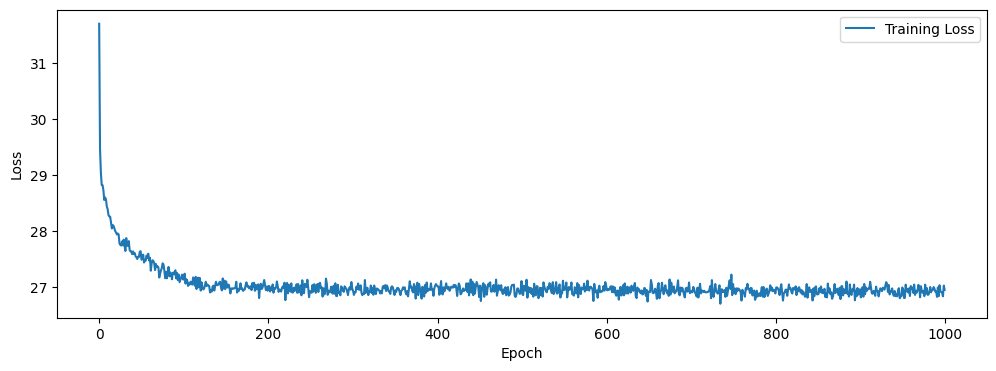

In [14]:
plt.figure(figsize=(12,4))
plt.plot(History.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
mae_list = []

for i in range(0,k_max+1):
  test_df = pd.read_sql_query('SELECT coordinatesB_{0}, volume FROM Data'.format(i), conn)
  test_df['new_coordinates'] = test_df['coordinatesB_{0}'.format(i)].apply(convert_to_int)
  test_df['volume'] = pd.to_numeric(test_df['volume'], errors='coerce')

  # We compute the MAE with respect the newdatabase.

  #preparing the data
  X_test = np.stack(test_df['new_coordinates'].values)
  y_test = test_df['volume'].values

  # Make predictions on the new input data
  new_y_pred = model.predict(X_test)
  mae = mean_absolute_error(y_test, new_y_pred)
  mae_list.append(mae)



1321/1321 [==============================] - 0s 231us/step


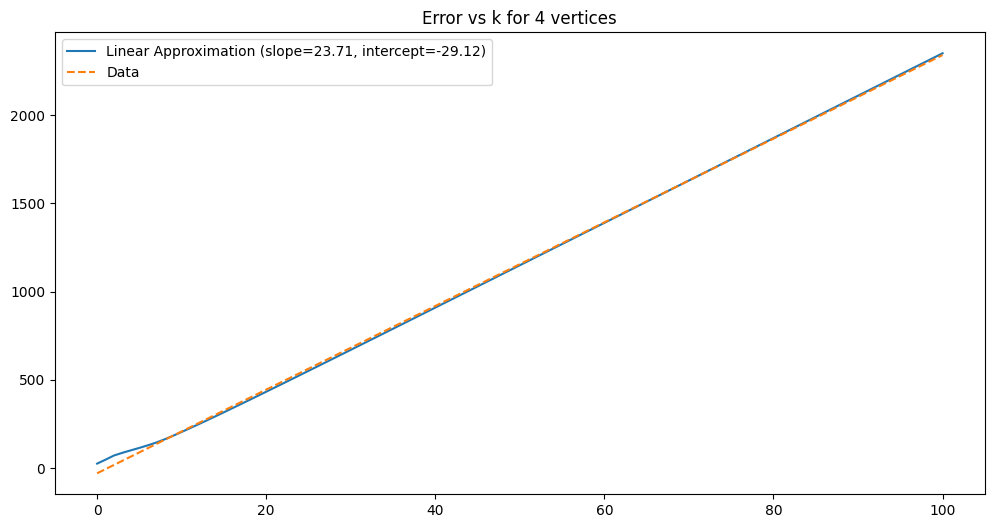

In [16]:
# Define the input data as a list
data = [i for i in range(0,k_max+1)]

# Convert the input data to a numpy array
x = np.array(data)

# Define the output data as a list
output = mae_list

# Convert the output data to a numpy array
y = np.array(output)

# Perform linear regression on the data
slope, intercept = np.polyfit(x, y, 1)

# Define a function for the linear approximation
def linear_approximation(x):
    return slope * x + intercept

# Plot the data and the linear approximation
plt.figure(figsize=(12,6))
plt.plot(x, y, label='Data')
plt.plot(x, linear_approximation(x), "--", label='Linear Approximation')
plt.legend(['Linear Approximation (slope={0:.2f}, intercept={1:.2f})'.format(slope, intercept), 'Data'])
plt.title("Error vs k for {} vertices".format(num_vertices))
plt.show()
